In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
%tensorflow_version 2.x

TensorFlow 2.x selected.


In [3]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import re 

#Ruta raiz
PATH = "/content/drive/My Drive/ConcursoDotCsv/Ejemplos/example_AtoB_tomosintesis/"

INPATH = PATH + "images_tomosintesis"


imgurls = !ls -1 "{INPATH}"



def sorted_nicely( l ): 
    """ Sort the given iterable in the way that humans expect.""" 
    convert = lambda text: int(text) if text.isdigit() else text 
    alphanum_key = lambda key: [ convert(c) for c in re.split('([0-9]+)', key) ] 
    return sorted(l, key = alphanum_key)

imgurls = sorted_nicely(imgurls)

print(len(imgurls))

70


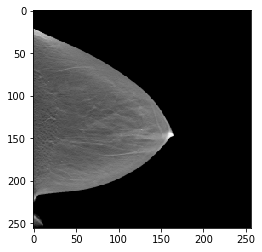

In [4]:
# Fcuniones para para cargar las imagenes a la red

def normalize(inimg):
  inimg = (inimg/127.5) - 1 

  return inimg

def load_image(filename):

  inimg = tf.cast(tf.image.decode_jpeg(tf.io.read_file(INPATH + '/' + filename)),tf.float32)[...,:3]

  inimg= normalize(inimg)

  return inimg

plt.imshow((load_image(imgurls[0]) + 1)/2)

In [5]:
evaluate_dataset = tf.data.Dataset.from_tensor_slices(imgurls)
evaluate_dataset = evaluate_dataset.map(load_image,num_parallel_calls=tf.data.experimental.AUTOTUNE)
evaluate_dataset = evaluate_dataset.batch(1)

In [0]:
# En este caso como no vamos a entrenar el modelo solo nos interesa la red generadora

from tensorflow.keras import *
from tensorflow.keras.layers import *

def downsample(filters, apply_batchnorm=True):

  result = Sequential() 

  initializer = tf.random_normal_initializer(0,0.02)

  #capa convolucional 

  result.add(Conv2D(filters,
                    kernel_size = 4,
                    strides = 2,
                    padding = "same",
                    kernel_initializer = initializer,
                    use_bias = not apply_batchnorm))

  # Capa de batch normalization 

  if apply_batchnorm:
    result.add(BatchNormalization())

  #Capa de activacion (leak relu)

  result.add(ReLU()) 

  return result 

downsample(64)

def upsample(filters, apply_dropout=False):

  result = Sequential() 

  initializer = tf.random_normal_initializer(0,0.02)

  #capa convolucional 

  result.add(Conv2DTranspose(filters,
                             kernel_size = 4,
                             strides = 2,
                             padding = "same",
                             kernel_initializer = initializer,
                             use_bias = False))

  # Capa de batch normalization 
  result.add(BatchNormalization())

  if apply_dropout:
    result.add(Dropout(0.5))
    

  #Capa de activacion (leak relu)
  result.add(ReLU()) 

  return result

upsample(64)


def Generator():
  inputs = tf.keras.layers.Input(shape=[None,None,3])

  down_stack = [
    downsample(64, apply_batchnorm=False),
    downsample(128),
    downsample(256),
    downsample(512),
    downsample(512),
    downsample(512),
    downsample(512),
    downsample(512),
  ]

  up_stack = [ 
    upsample(512,apply_dropout=True),
    upsample(512,apply_dropout=True),
    upsample(512,apply_dropout=True),
    upsample(512),
    upsample(256),
    upsample(128),
    upsample(64),
  ]

  initializer = tf.random_normal_initializer(0,0.02)

  last = Conv2DTranspose(filters=3,
                         kernel_size = 4,
                         strides = 2,
                         padding = "same",
                         kernel_initializer = initializer,
                         activation = "tanh")
  

  x = inputs

  s = []

  concat = Concatenate()

  for down in down_stack:
    x = down(x)
    s.append(x)

  s = reversed(s[:-1])

  for up,sk in zip(up_stack,s):
    x = up(x)
    x = concat([x,sk])

  last = last(x)

  return Model(inputs = inputs, outputs = last)

generator = Generator()



In [7]:
#Cargando modelo entrenado, en este caso model_trained_AtoB

checkpoint = tf.train.Checkpoint(generator = generator)

checkpoint.restore(tf.train.latest_checkpoint("/content/drive/My Drive/ConcursoDotCsv/Modelos_Entrenados/model_trained_AtoB/checkpoints"))

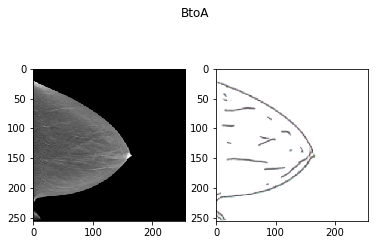

In [8]:
# prueba de que el modelo entrenado fue cargado correctamente 

for inimg in evaluate_dataset.take(2):
  w1 = inimg

gen_output = generator(w1,training=False)


fig, axs = plt.subplots(1,2)
fig.suptitle('BtoA')
axs[0].imshow((inimg[0,...]+1)/2)
axs[1].imshow((gen_output[0,...]+1)/2)

In [0]:
# Funcion que evalua cada imagen en el modelo 
#Como queremos crear un modelo 3D a partir de las salidas en ImageJ entonces al guardar colocamos 1-prediction[0,...] 
#para obtener el negativo de la imagen 

def generate_images(model,evaluate_input,num_img=False,display_imgs=True):

  prediction = model(evaluate_input)
  
  if num_img:
    save_filename = str(num_img)
    tf.keras.preprocessing.image.save_img(PATH + "results_tomosintesis/" + save_filename + ".jpg",1-prediction[0,...])

  plt.figure(figsize=(10,10))

  display_list = [evaluate_input[0],prediction[0]]

  title = ["Input Image" , "Predicted Image"]

  if display_imgs: 
    for i in range(2):
      plt.subplot(1,2,i+1)
      plt.title(title[i])
      # getting the pixel value between [0,1] to plot it.
      plt.imshow(display_list[i]*0.5 + 0.5)
      plt.axis("off")

  plt.show()
  return (1-prediction[0,...])

In [0]:
# Para guardar resultados en carpeta seleccionada anateriormente

for i,inp in enumerate(evaluate_dataset.take(168)):
  generate_images(generator,inp,i)

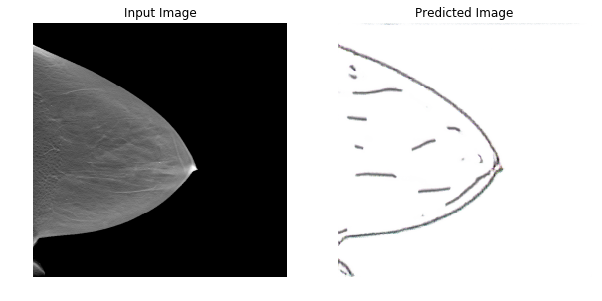

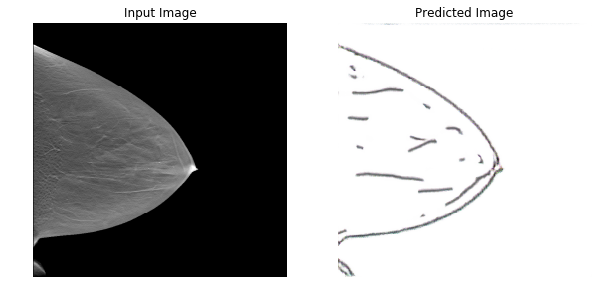

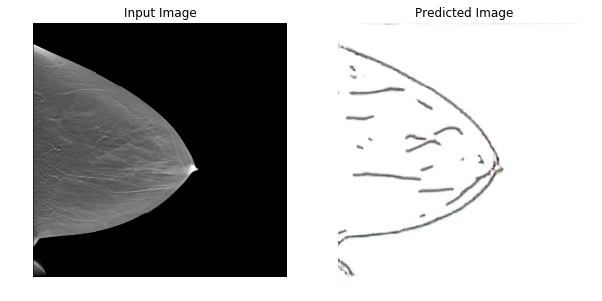

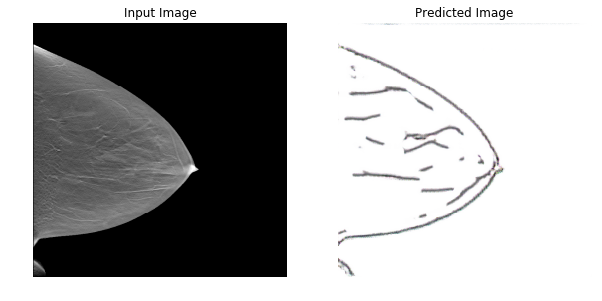

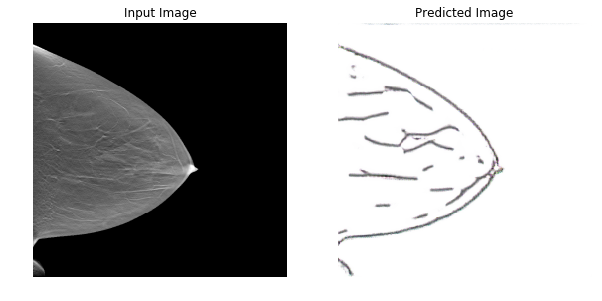

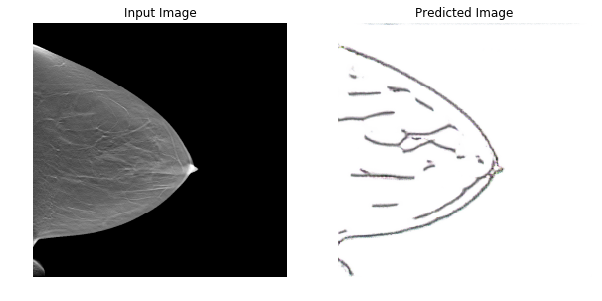

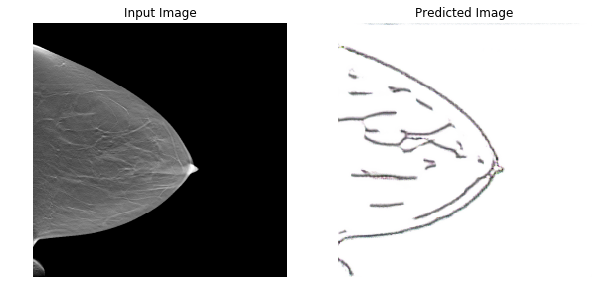

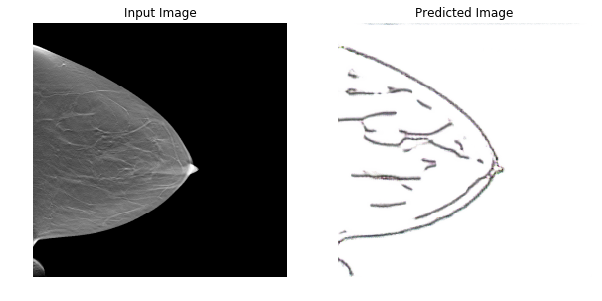

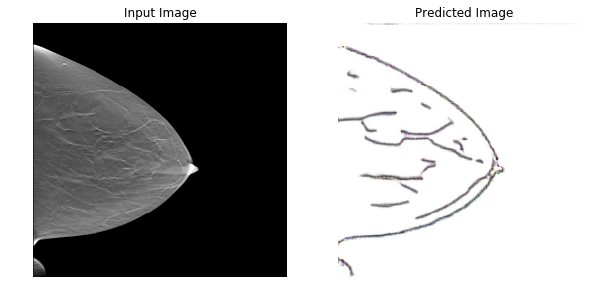

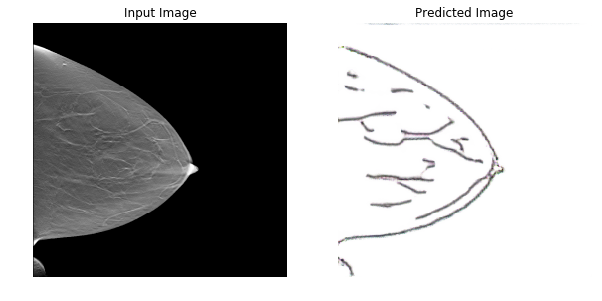

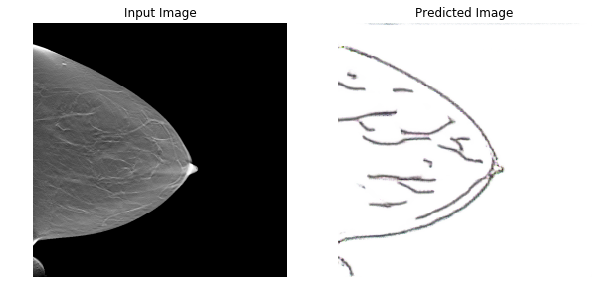

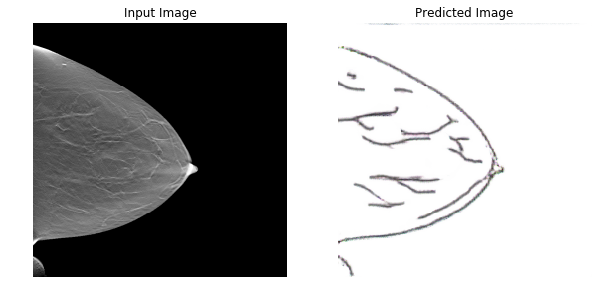

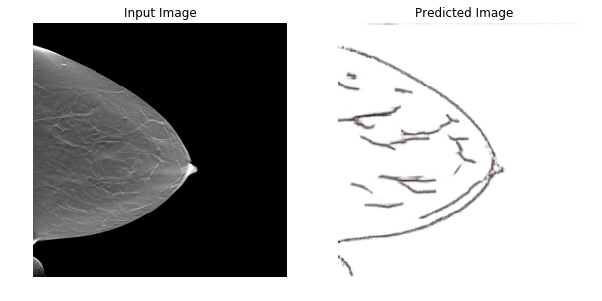

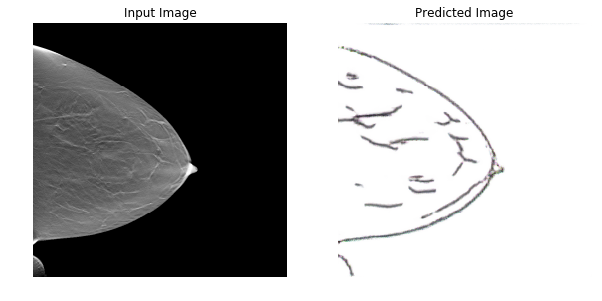

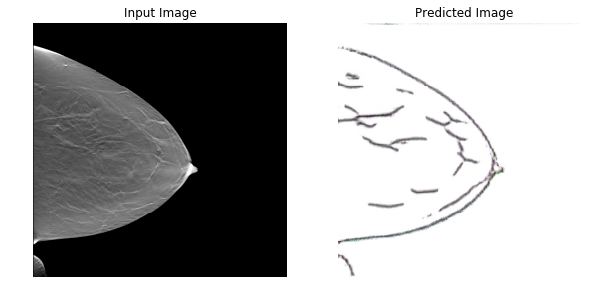

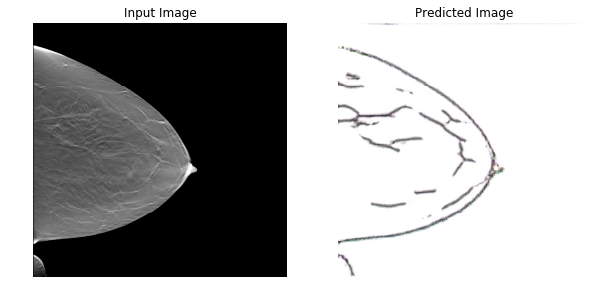

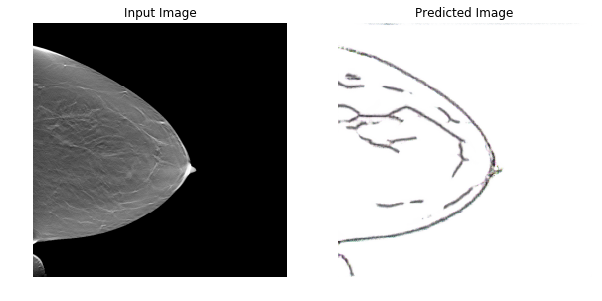

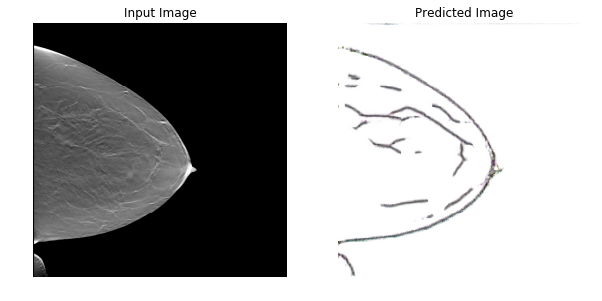

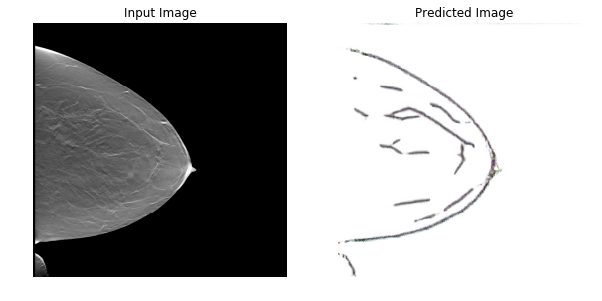

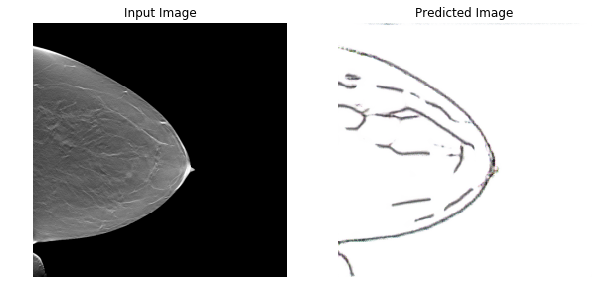

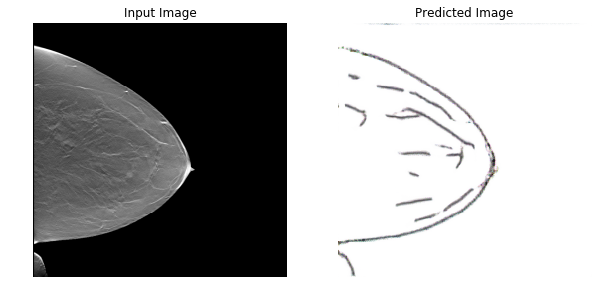

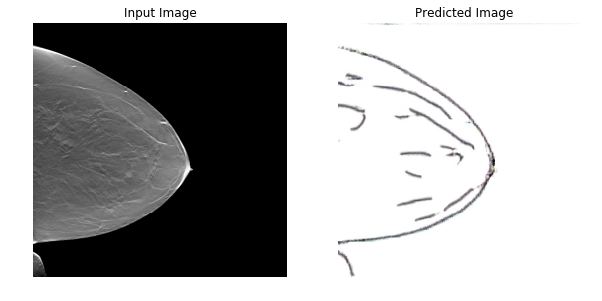

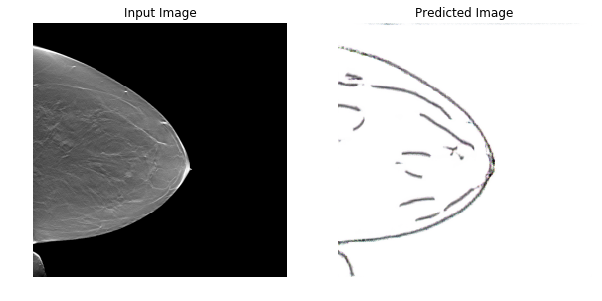

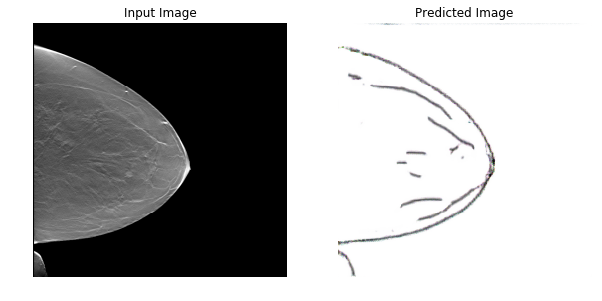

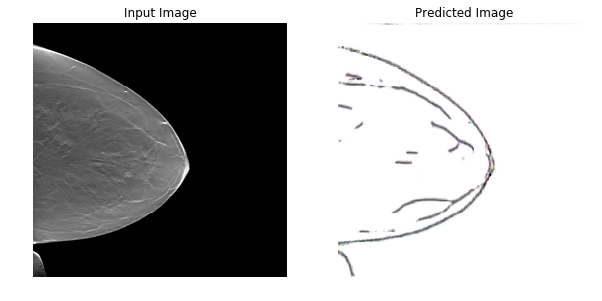

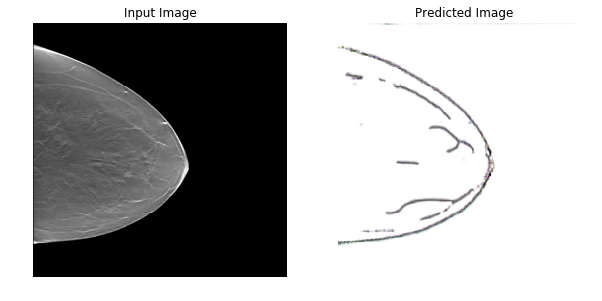

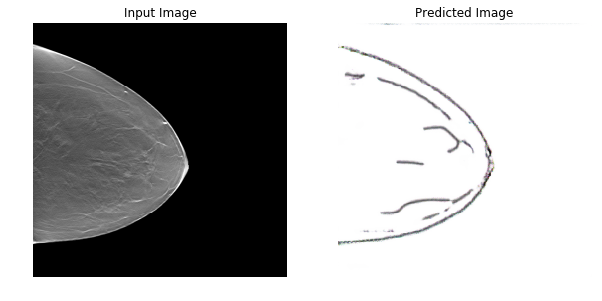

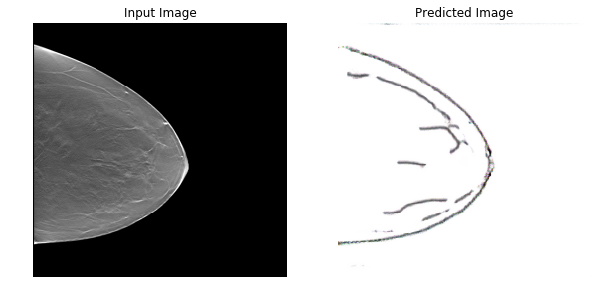

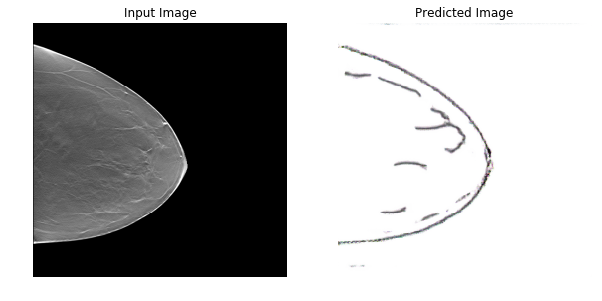

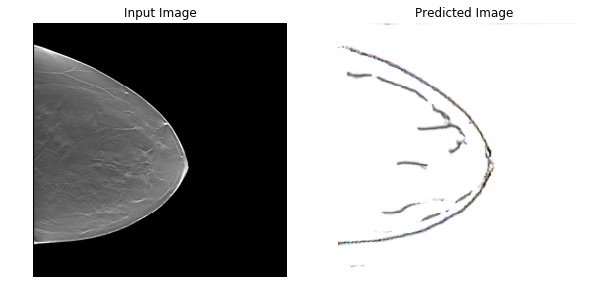

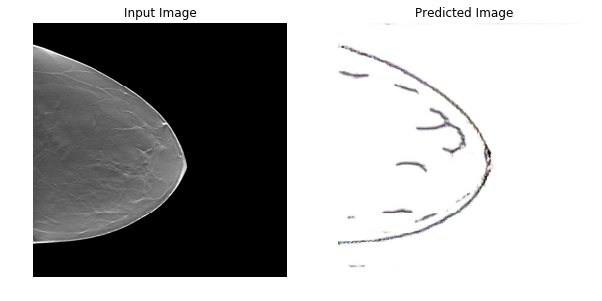

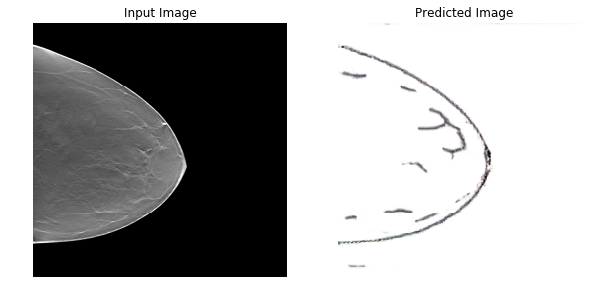

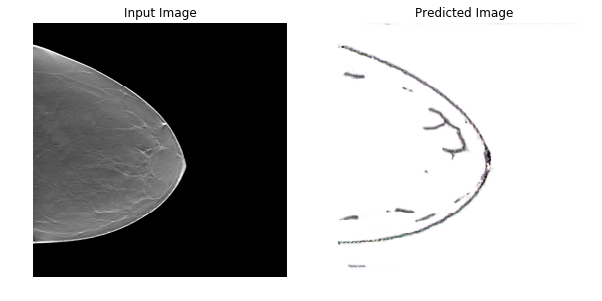

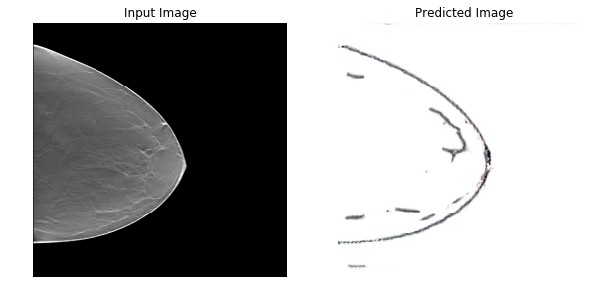

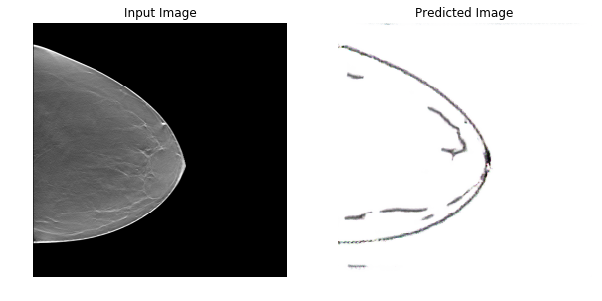

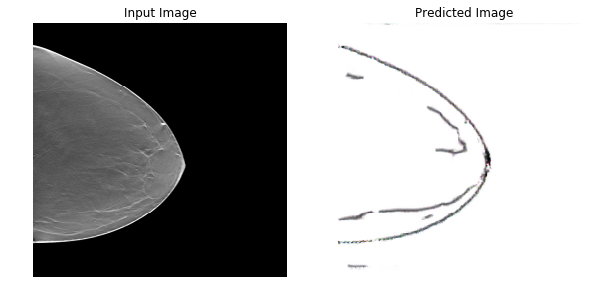

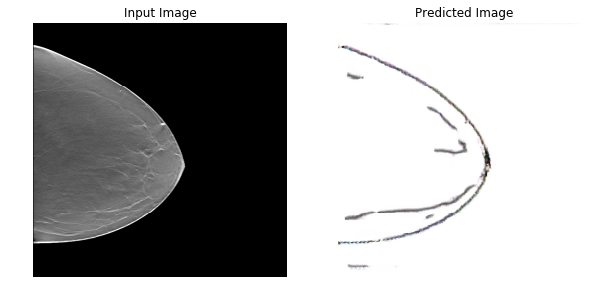

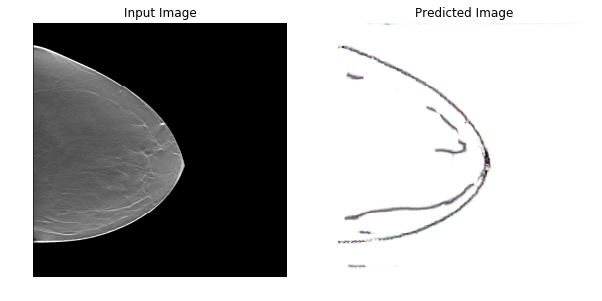

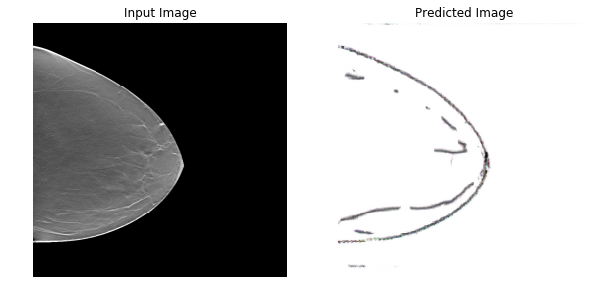

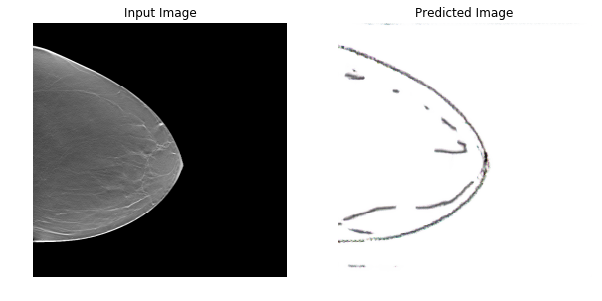

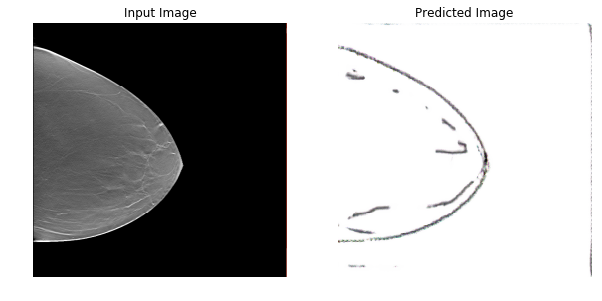

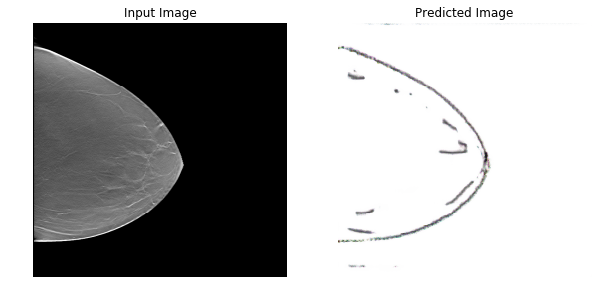

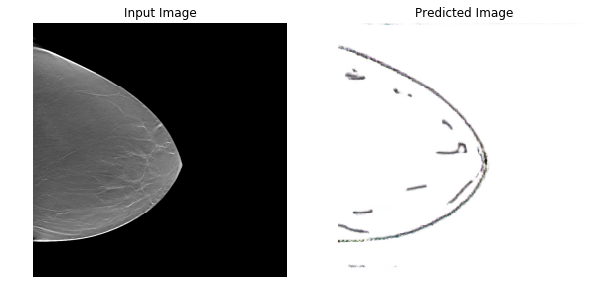

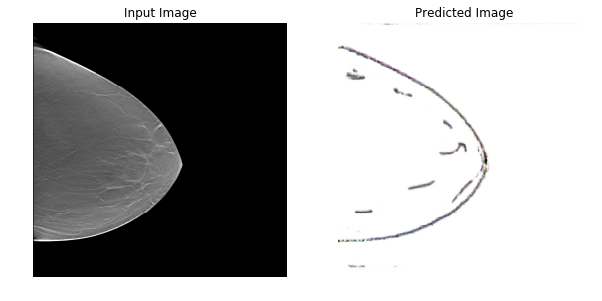

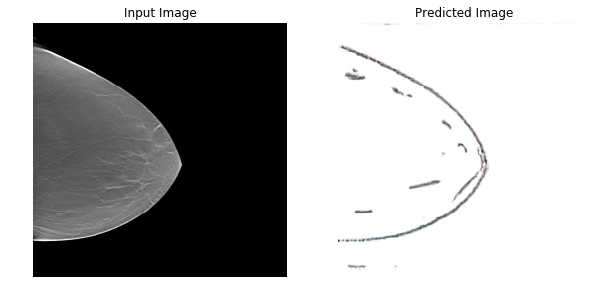

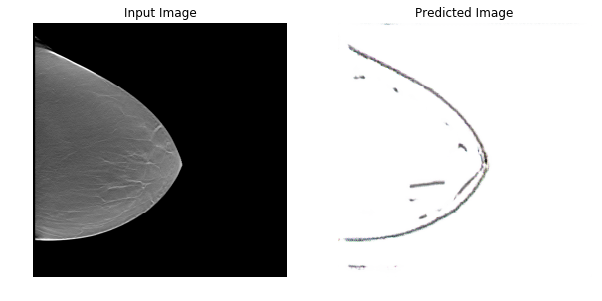

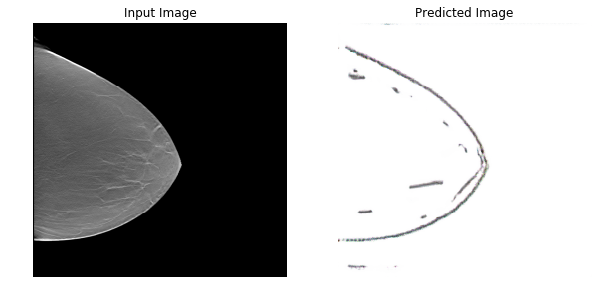

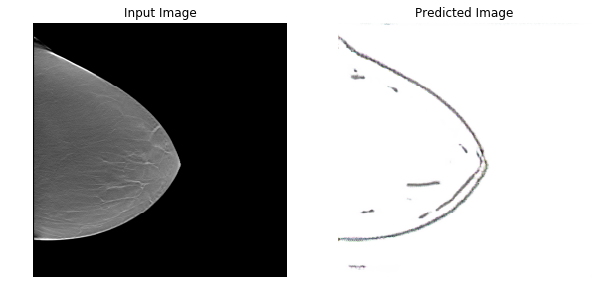

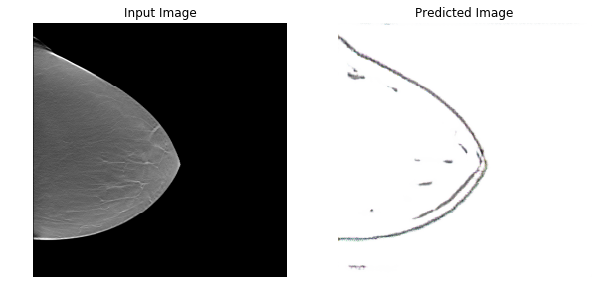

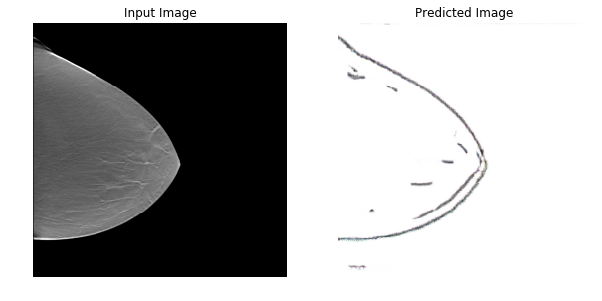

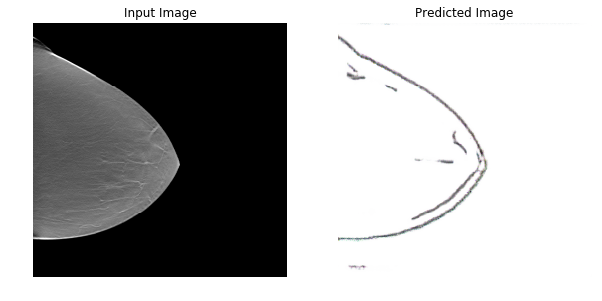

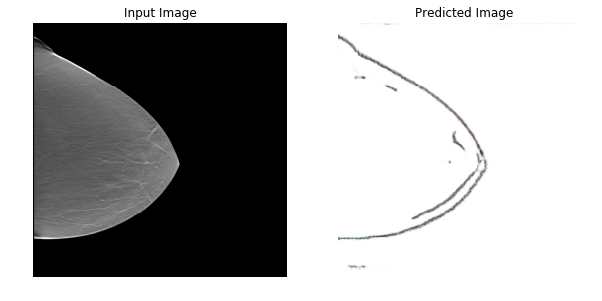

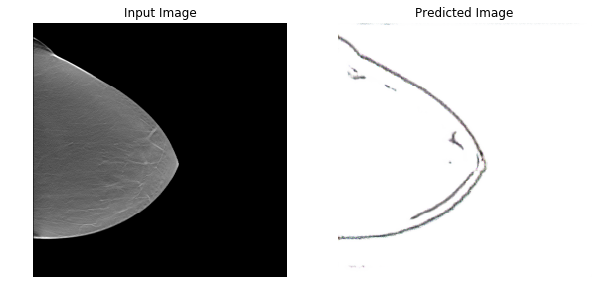

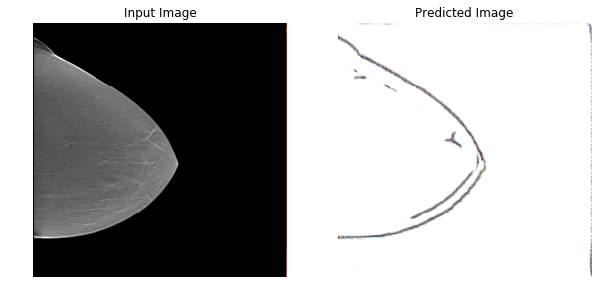

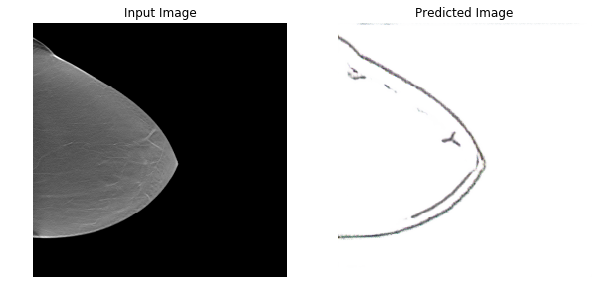

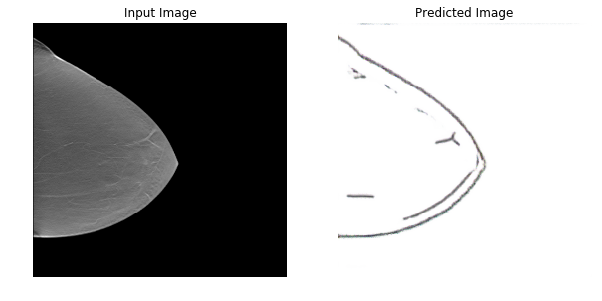

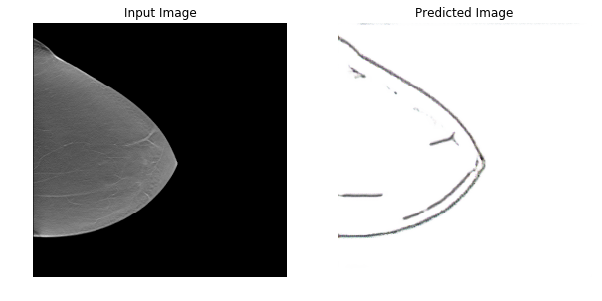

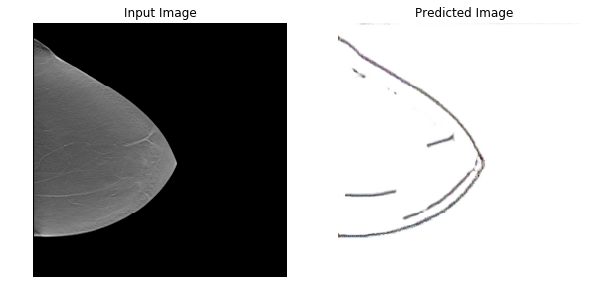

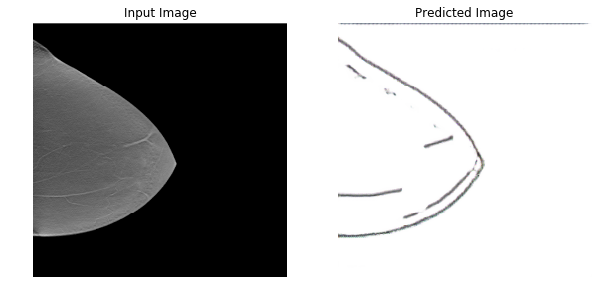

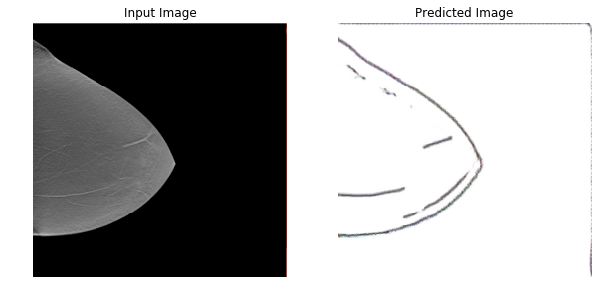

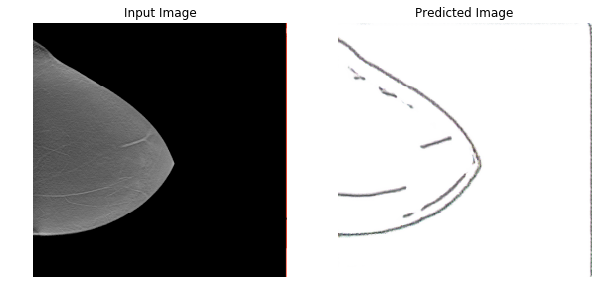

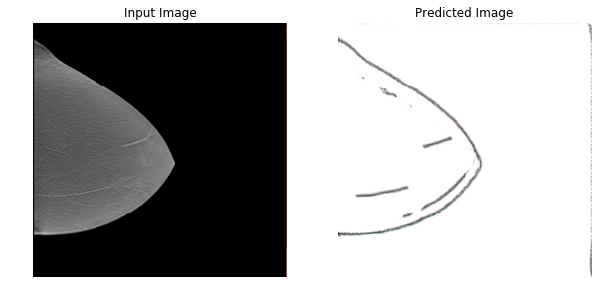

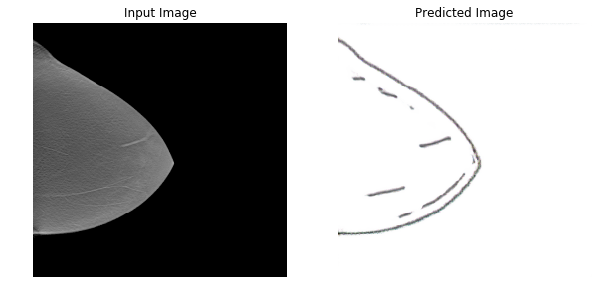

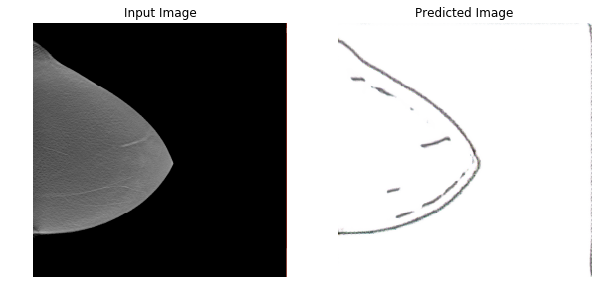

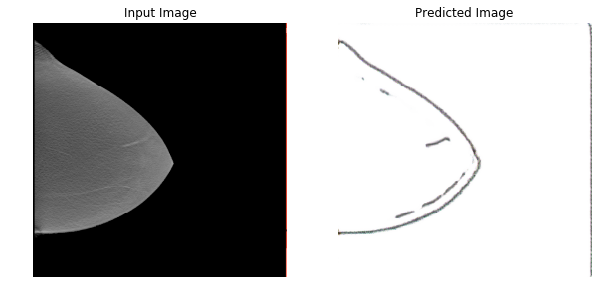

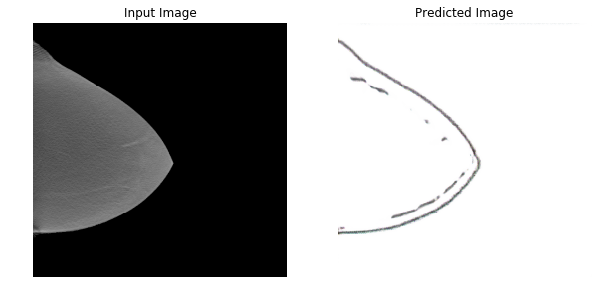

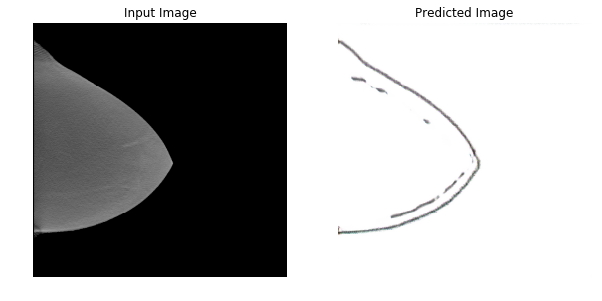

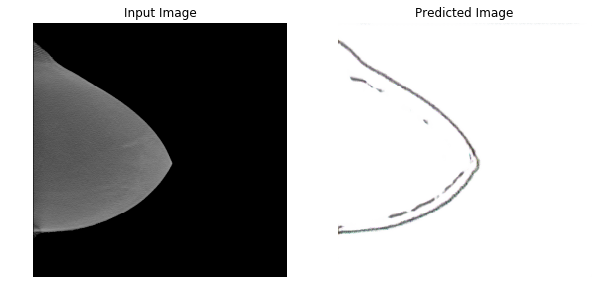

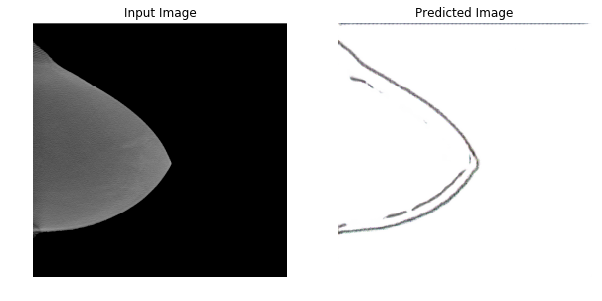

In [11]:
# imprimir predicciones y crear stack para crear modelo 3d 

stack = tf.zeros([1,256, 256], tf.float32)
for i,inp in enumerate(evaluate_dataset.take(69)):
  x = generate_images(generator,inp)
  x = tf.image.rgb_to_grayscale(x,name=None)
  x = tf.squeeze(x)
  x = tf.where(x > 0.19,1,0)
  x = tf.cast(x, tf.float32)
  x = tf.expand_dims(x,axis=0)
  stack =  tf.concat([stack, x], 0)

In [0]:
# Es necesario importar estas librerias para sustraer los vertices a partir del stack
# Hay dos maneras de visualizar el modelo 3d una con la matplotlib y 
#otra interactiva con tensorflow grapichs en este caso usaremos las dos 

%matplotlib inline

import scipy.ndimage
from skimage import measure, morphology, io
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

In [0]:
def plot_3d(image, threshold=-300):
    
    # Position the scan upright, 
    # so the head of the patient would be at the top facing the camera
    
    p = image.transpose(2,1,0)
    verts, faces = measure.marching_cubes_classic(p, threshold)

    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')

    verts = (verts/np.max(verts))+0.5

    Rotation = np.array([[1,0,0],[0,np.cos(2.74),-np.sin(2.74)],[0,np.sin(2.74),np.cos(2.74)]],dtype=np.float32)
    verts = verts@Rotation
    Rotation = np.array([[np.cos(2),0,np.sin(2)],[0,1,0],[-np.sin(2),0,np.cos(2)]],dtype=np.float32)
    verts = verts@Rotation
    Rotation = np.array([[np.cos(2),-np.sin(2),0],[0,1,0],[np.sin(2),np.cos(2),0]],dtype=np.float32)
    verts = verts@Rotation
    mesh = Poly3DCollection(verts[faces], alpha=0.70)
    face_color = [0.45, 0.45, 0.75]
    mesh.set_facecolor(face_color)
    ax.add_collection3d(mesh)

    ax.set_xlim(-0.0,1.0, p.shape[0])
    ax.set_ylim(-1.5,-0.5, p.shape[1])
    ax.set_zlim(-0.06,0.02, p.shape[2])

    plt.show()

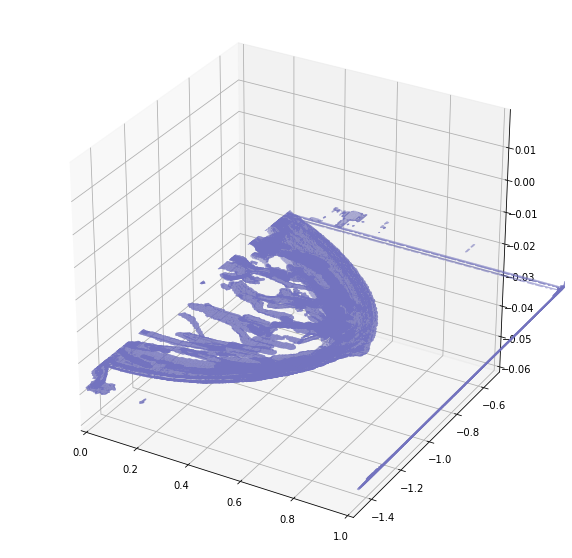

In [0]:
plot_3d(stack.numpy(), 0.09)

In [13]:
# Es necesario instalar tensorflow graphics
!pip install tensorflow_graphics

     |████████████████████████████████| 245kB 2.8MB/s 


In [14]:
from tensorflow_graphics.notebooks import mesh_viewer

In [0]:
verts, faces = measure.marching_cubes_classic(stack.numpy(), 0.09)
verts = np.array(verts,dtype=np.float32)
faces = np.array(faces,dtype=np.int32)
labels=np.ones((np.shape(verts)[0]))*13
labels = np.array(labels,dtype=np.int32)

In [0]:
input_graph = tf.Graph()
input_mesh_data = {
    'vertices': ((verts/255)-0.5),
    'faces': faces,
    'vertex_colors': mesh_viewer.SEGMENTATION_COLORMAP[labels],
}
input_viewer = mesh_viewer.Viewer(input_mesh_data)